In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [277]:
data = pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv")

In [278]:
num_cols = ["crime_burglary","crime_risk", "Norm_fire_risk", "crime_arson", "ISO", "Weather_risk", "Geographical_risk", "Premium_remain",
            "crime_property_type", "crime_neighbour_watch", "Previous_claims", "Exposure", "crime_area", "Norm_monthly_rent", "No_claim_Years",
            "crime_residents", "Norm_area_m", "Property_size", "Residents", "crime_community", "Loan_mortgage", "Premium_renew"]
text_cols = ["ISO_desc"]
cat_cols = ["Renewal_Type", "Commercial", "Renewal_class", "ISO_cat", "Rating_Class", "Sub_Renewal_Class", "Sub_Rating_Class"] 
target = "loss"

## EDA

In [279]:
data.head()

,loss,Exposure,Rating_Class,Sub_Rating_Class,Renewal_class,Sub_Renewal_Class,Property_size,Residents,Commercial,Norm_fire_risk,...,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO,ISO_cat,ISO_desc
0,0.07,3.0,H1,NaN,NaN,NaN,3.0,4.0,NaN,4.314082,...,0.939346,1.708534,0.808015,1.040819,1.171366,0.284447,0.313157,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...,which and floors. greater roof _—– modified an...
1,0.13,NaN,M1,NaN,NaN,NaN,6.0,1.0,NaN,4.171214,...,NaN,NaN,NaN,NaN,NaN,0.006305,0.889677,6,ISO 6 - Fire Resistive (FR),bearing are walls deck/cover precast and/or co...
2,0.02,NaN,M1,NaN,NaN,NaN,4.0,1.0,NaN,4.171214,...,NaN,NaN,NaN,NaN,NaN,0.019372,0.276507,1,ISO 1 Frame (combustible walls or roof),*BUR 1B and covers the *Single-ply wood/hardip...
3,0.13,NaN,M1,NaN,NaN,NaN,2.0,1.0,NaN,4.171214,...,1.632539,1.205554,1.999838,1.665336,1.779279,0.085413,0.124679,1,ISO 1 Frame (combustible walls or roof),"frame anchorage are wood. *Less Habitational, ..."
4,0.04,3.0,H1,NaN,NaN,NaN,4.0,3.0,NaN,4.314082,...,0.638615,0.567431,0.751454,0.585363,0.729587,5.570830,0.703054,6,ISO 6 - Fire Resistive (FR),is roof deck structural on roof - poured occup...


In [280]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loss                   1217 non-null   float64
 1   Exposure               210 non-null    float64
 2   Rating_Class           1130 non-null   object 
 3   Sub_Rating_Class       5 non-null      object 
 4   Renewal_class          124 non-null    object 
 5   Sub_Renewal_Class      103 non-null    object 
 6   Property_size          1216 non-null   float64
 7   Residents              1212 non-null   float64
 8   Commercial             998 non-null    object 
 9   Norm_fire_risk         1217 non-null   float64
 10  Norm_monthly_rent      1217 non-null   float64
 11  Loan_mortgage          196 non-null    float64
 12  No_claim_Years         1217 non-null   float64
 13  Previous_claims        353 non-null    float64
 14  Norm_area_m            1047 non-null   float64
 15  Prem

#### There are columns with too much NaN. Trees does not care about it, but it can impact on LR.

In [281]:
data[cat_cols].nunique(axis = 0)

Renewal_Type          2
Commercial            2
Renewal_class         6
ISO_cat               6
Rating_Class         38
Sub_Renewal_Class     3
Sub_Rating_Class      3
dtype: int64

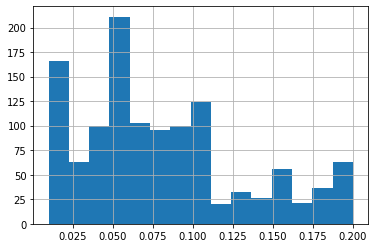

In [282]:
data[target].hist(bins = 15)

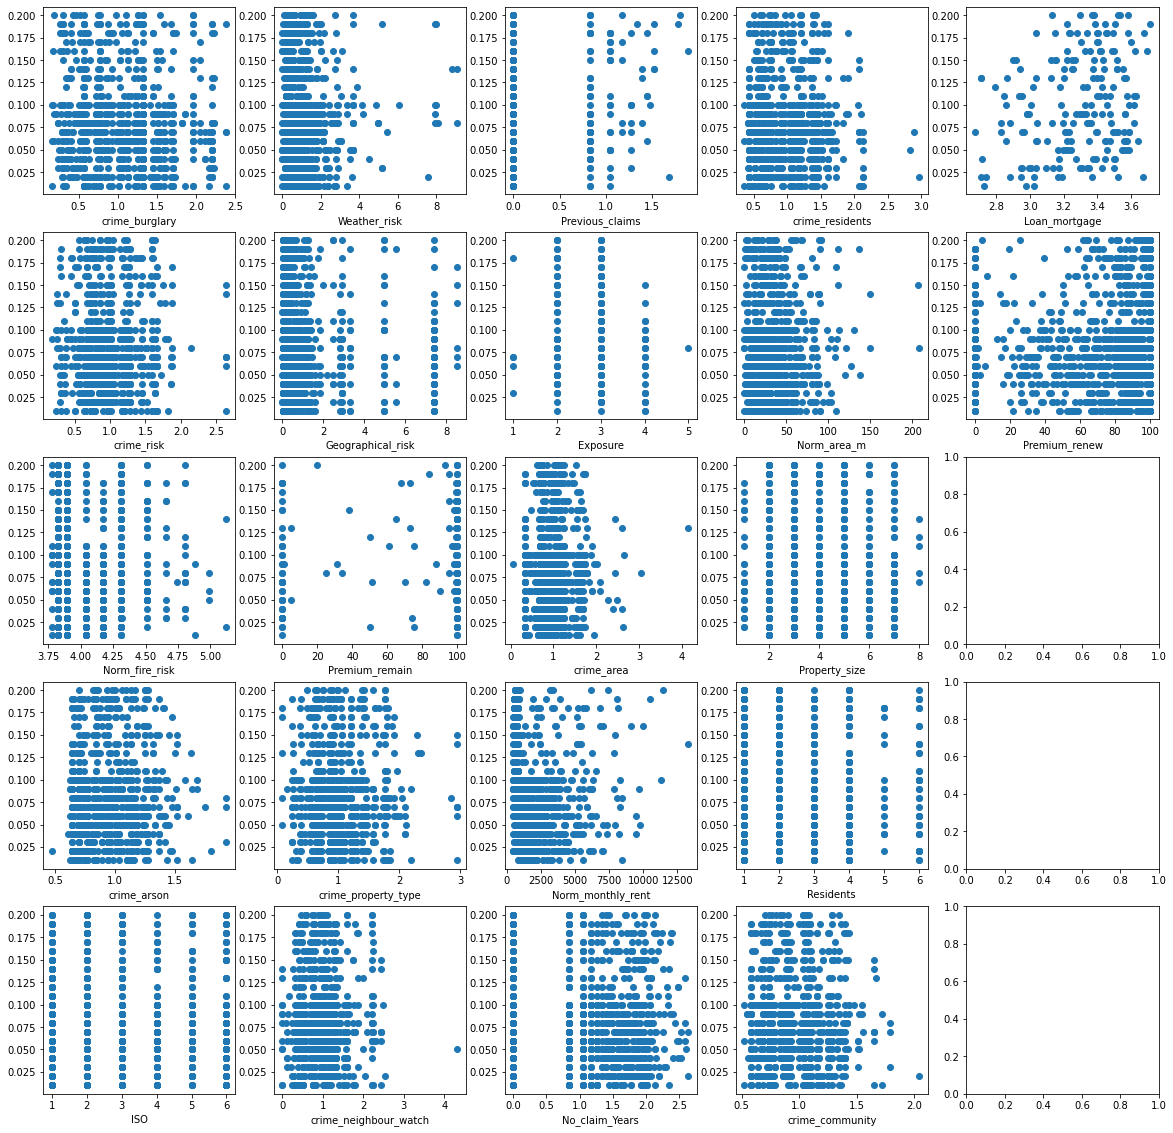

In [283]:
fig, ax = plt.subplots(5,5,figsize = (20,20))
for i in range(len(num_cols)):
    ax[i%5][i//5].scatter(data[num_cols[i]], data[target])
    ax[i%5][i//5].set_xlabel(num_cols[i])

#### Some 'numeric' columns does not seem numeric. Let's explore some of them. 

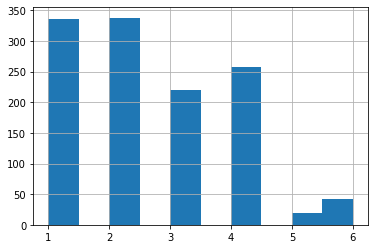

In [284]:
data.Residents.hist()

In [285]:
data.Property_size.nunique(), data.Exposure.nunique()

(8, 5)

#### `Residents`, `Exposure` and `Property_size` seems more categorical, so I will move them to categorical features. 

In [286]:
num_cols.remove("Property_size")
num_cols.remove("Residents")
num_cols.remove("Exposure")
cat_cols.append("Exposure")
cat_cols.append("Property_size")
cat_cols.append("Residents")

In [287]:
data[["ISO", "ISO_cat"]].drop_duplicates()

,ISO,ISO_cat
0,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...
1,6,ISO 6 - Fire Resistive (FR)
2,1,ISO 1 Frame (combustible walls or roof)
7,3,ISO 3 - Non Combustible (NC)
10,2,ISO 2 Joisted Masonry (JM) (noncombustible)
12,4,ISO 4 - Masonry Non Combustible (MNC)


`ISO` is the numeric version of `ISO_cat`, so I remove it

In [288]:
num_cols.remove("ISO")

In [289]:
data[num_cols].corrwith(data[target])

crime_burglary          -0.062627
crime_risk               0.004976
Norm_fire_risk           0.012053
crime_arson              0.023943
Weather_risk             0.043894
Geographical_risk       -0.020838
Premium_remain           0.143605
crime_property_type      0.026172
crime_neighbour_watch   -0.000232
Previous_claims          0.207785
crime_area               0.043476
Norm_monthly_rent       -0.047910
No_claim_Years          -0.021623
crime_residents         -0.045156
Norm_area_m              0.019041
crime_community         -0.012874
Loan_mortgage            0.231986
Premium_renew            0.039122
dtype: float64

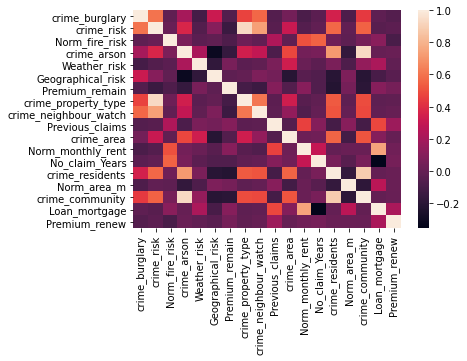

In [290]:
import seaborn as sns
sns.heatmap(data[num_cols].corr())

#### Some of the columns are highly correlated, so I will use l1 regularization to get rid of unessesary features.

In [96]:
for col in cat_cols:
    print(data[col].value_counts())

A    998
B    219
Name: Renewal_Type, dtype: int64
A    854
B    144
Name: Commercial, dtype: int64
B    92
C    12
D    11
A     4
F     3
E     2
Name: Renewal_class, dtype: int64
ISO 1 Frame (combustible walls or roof)                 287
ISO 2 Joisted Masonry (JM) (noncombustible)             285
ISO 3 - Non Combustible (NC)                            283
ISO 4 - Masonry Non Combustible (MNC)                   121
ISO 6 - Fire Resistive (FR)                             121
ISO 5 - Modified or Semi Fire Resistive (MFR or SFR)    120
Name: ISO_cat, dtype: int64
H1    224
M1    187
O2     94
D3     90
I1     67
E3     53
R5     35
D1     34
S1     34
C1     33
L1     28
G1     24
P1     22
A1     21
J4     21
E1     18
R3     16
J5     13
H2     13
J2     13
E4     11
R6     11
J1     10
N1      7
G2      7
B1      7
E2      7
F1      5
O1      4
H3      3
D4      3
R7      3
K1      3
J3      3
J6      3
R8      1
E5      1
R1      1
Name: Rating_Class, dtype: int64
B    68
A    25
C

## Feature enginering

In [296]:
nan_cols = data.loc[:, data.count(axis = 0) < data.shape[0]*0.5].columns
nan_cols

Index(['Exposure', 'Sub_Rating_Class', 'Renewal_class', 'Sub_Renewal_Class',
       'Loan_mortgage', 'Previous_claims', 'Premium_remain'],
      dtype='object')

In [298]:
num_cols_lr = [i for i in num_cols if i not in nan_cols]
len(num_cols_lr), len(num_cols) 

(15, 18)

In [300]:
data[cat_cols] = data[cat_cols].astype(str)

## Pipeline

In [366]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.compose import TransformedTargetRegressor

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words(['english'])

##
#  Pipeline for linear regression
##
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
categoric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = "nan")),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])
text_pipeline = Pipeline(steps=[    
    ('vectorizer', TfidfVectorizer(stop_words = stop_words, ngram_range = (1,3), max_features = 100)),
  ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_cols_lr),
        ('cat', categoric_pipeline, cat_cols),
        ('text', text_pipeline, text_cols[0])
    ])

est_lr = Pipeline(steps=[('preprocessor', preprocessor),
                         ('lr', ElasticNet())])

[nltk_data] Downloading package stopwords to /home/nata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [367]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = -999))])
categoric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = "nan")),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])
text_pipeline = Pipeline(steps=[    
    ('vectorizer', TfidfVectorizer(stop_words = stop_words, ngram_range = (1,3), max_features = 100)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_cols),
        ('cat', categoric_pipeline, cat_cols),
        ('text', text_pipeline, text_cols[0])
    ])

est_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor(criterion = 'mae'))])

## Training and estimating

In [368]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import QuantileTransformer, quantile_transform

X_train, X_test, y_train, y_test = train_test_split(data[num_cols+cat_cols+text_cols], data[target], test_size=0.15, random_state=10, shuffle=True)

In [370]:
gs = GridSearchCV(estimator=est_lr, param_grid={'lr__l1_ratio': [i/10 for i in range(11)],
                                                'lr__alpha': [i/10 for i in range(11)]
                                               }, 
                  scoring='neg_mean_absolute_error', cv=3, refit=True, verbose=10)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 121 candidates, totalling 363 fits
[CV] lr__alpha=0.0, lr__l1_ratio=0.0 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_pa

[CV] .... lr__alpha=0.0, lr__l1_ratio=0.0, score=-0.045, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.0, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.0, score=-0.042, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=0.1 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.1, score=-0.045, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=0.1 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.1, score=-0.042, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=0.1 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.7s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.1, score=-0.042, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=0.2 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.5s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.2, score=-0.045, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=0.2 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.3s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.2, score=-0.042, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=0.2 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.1s remaining:    0.0s
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.2, score=-0.042, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=0.3 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.3, score=-0.045, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.3 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.3, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.3 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.3, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.4 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.4, score=-0.045, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.4 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.4, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.4 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.4, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.5 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.5, score=-0.045, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.5 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.5, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.5 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.5, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.6 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.6, score=-0.045, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.6 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.6, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.6 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.6, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.7 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.7, score=-0.045, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.7 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.7, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.7 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.7, score=-0.042, total=   0.6s
[CV] lr__alpha=0.0, lr__l1_ratio=0.8 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.8, score=-0.045, total=   0.6s
[CV] lr__alpha=0.0, lr__l1_ratio=0.8 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.8, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.8 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.8, score=-0.042, total=   0.6s
[CV] lr__alpha=0.0, lr__l1_ratio=0.9 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.9, score=-0.045, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.9 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.9, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=0.9 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=0.9, score=-0.042, total=   0.7s
[CV] lr__alpha=0.0, lr__l1_ratio=1.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5385760685464491, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=1.0, score=-0.045, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=1.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5948047376809941, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV] .... lr__alpha=0.0, lr__l1_ratio=1.0, score=-0.042, total=   0.8s
[CV] lr__alpha=0.0, lr__l1_ratio=1.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5831797810451307, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.0, lr__l1_ratio=1.0, score=-0.042, total=   0.8s
[CV] lr__alpha=0.1, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7451366867752195, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.1, lr__l1_ratio=0.0, score=-0.040, total=   0.8s
[CV] lr__alpha=0.1, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8000861874827325, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.1, lr__l1_ratio=0.0, score=-0.037, total=   0.8s
[CV] lr__alpha=0.1, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7581255666990752, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.1, lr__l1_ratio=0.0, score=-0.039, total=   0.8s
[CV] lr__alpha=0.1, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.1, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=0.1, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.1, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.1, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.1, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=0.1, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.1, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.1, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.1, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=0.1, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.1, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.1, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7710064820727471, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.2, lr__l1_ratio=0.0, score=-0.039, total=   0.8s
[CV] lr__alpha=0.2, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8230219060219992, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.2, lr__l1_ratio=0.0, score=-0.037, total=   0.8s
[CV] lr__alpha=0.2, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7784306237708418, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.2, lr__l1_ratio=0.0, score=-0.039, total=   0.8s
[CV] lr__alpha=0.2, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.2, lr__l1_ratio=0.1, score=-0.040, total=   0.1s
[CV] lr__alpha=0.2, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.2, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.2, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.2, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=0.2, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.2, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.2, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.2, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=0.2, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.2, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.2, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7856837367057843, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.3, lr__l1_ratio=0.0, score=-0.039, total=   0.7s
[CV] lr__alpha=0.3, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8357539553857053, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.3, lr__l1_ratio=0.0, score=-0.037, total=   0.7s
[CV] lr__alpha=0.3, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7899793805925147, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.3, lr__l1_ratio=0.0, score=-0.040, total=   0.7s
[CV] lr__alpha=0.3, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.3, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=0.3, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.3, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.3, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.3, lr__l1_ratio=0.1, score=-0.041, total=   0.1s
[CV] lr__alpha=0.3, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.3, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.3, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.3, lr__l1_ratio=0.2, score=-0.038, total=   0.1s
[CV] lr__alpha=0.3, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.3, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.3, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7956361816048854, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.4, lr__l1_ratio=0.0, score=-0.039, total=   0.7s
[CV] lr__alpha=0.4, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8442557959447154, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.4, lr__l1_ratio=0.0, score=-0.037, total=   0.7s
[CV] lr__alpha=0.4, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7977773772893412, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.4, lr__l1_ratio=0.0, score=-0.040, total=   0.7s
[CV] lr__alpha=0.4, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.4, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=0.4, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.4, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.4, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.4, lr__l1_ratio=0.1, score=-0.041, total=   0.1s
[CV] lr__alpha=0.4, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.4, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.4, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.4, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=0.4, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.4, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.4, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.802969598911128, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.5, lr__l1_ratio=0.0, score=-0.039, total=   0.7s
[CV] lr__alpha=0.5, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8504449690802824, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.5, lr__l1_ratio=0.0, score=-0.037, total=   0.7s
[CV] lr__alpha=0.5, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8034829665699537, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.5, lr__l1_ratio=0.0, score=-0.040, total=   0.7s
[CV] lr__alpha=0.5, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.5, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=0.5, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.5, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.5, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.5, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=0.5, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.5, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.5, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.5, lr__l1_ratio=0.2, score=-0.038, total=   0.1s
[CV] lr__alpha=0.5, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.5, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.5, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8086515705735562, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.6, lr__l1_ratio=0.0, score=-0.039, total=   0.8s
[CV] lr__alpha=0.6, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8551938815510381, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.6, lr__l1_ratio=0.0, score=-0.037, total=   0.8s
[CV] lr__alpha=0.6, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.807869385596395, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.6, lr__l1_ratio=0.0, score=-0.040, total=   0.8s
[CV] lr__alpha=0.6, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.6, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=0.6, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.6, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.6, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.6, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=0.6, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.6, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.6, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.6, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=0.6, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.6, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.6, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8132081600286051, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.7, lr__l1_ratio=0.0, score=-0.039, total=   0.8s
[CV] lr__alpha=0.7, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8589720694240187, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.7, lr__l1_ratio=0.0, score=-0.037, total=   0.9s
[CV] lr__alpha=0.7, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8113600638300293, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.7, lr__l1_ratio=0.0, score=-0.040, total=   0.8s
[CV] lr__alpha=0.7, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.7, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=0.7, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.7, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.7, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.7, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=0.7, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.7, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.7, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.7, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=0.7, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.7, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.7, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8169562603872564, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.8, lr__l1_ratio=0.0, score=-0.039, total=   0.7s
[CV] lr__alpha=0.8, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8620595477165817, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.8, lr__l1_ratio=0.0, score=-0.038, total=   0.7s
[CV] lr__alpha=0.8, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8142105700866574, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.8, lr__l1_ratio=0.0, score=-0.040, total=   0.7s
[CV] lr__alpha=0.8, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.8, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=0.8, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.8, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.8, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.8, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=0.8, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.8, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.8, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.8, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=0.8, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.8, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.8, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8201006073148001, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.9, lr__l1_ratio=0.0, score=-0.039, total=   0.7s
[CV] lr__alpha=0.9, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8646355128733931, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.9, lr__l1_ratio=0.0, score=-0.038, total=   0.7s
[CV] lr__alpha=0.9, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8165858194027708, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=0.9, lr__l1_ratio=0.0, score=-0.040, total=   0.7s
[CV] lr__alpha=0.9, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.9, lr__l1_ratio=0.1, score=-0.040, total=   0.1s
[CV] lr__alpha=0.9, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.9, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=0.9, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=0.9, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=0.9, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.9, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=0.9, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.9, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=0.9, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=0.9, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=0.9, lr__l1_ratio=0.3 .................................
[CV] .

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8227804418974437, tolerance: 0.00017159976777939047
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=1.0, lr__l1_ratio=0.0, score=-0.039, total=   0.7s
[CV] lr__alpha=1.0, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8668207725668988, tolerance: 0.00017895117561683604
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=1.0, lr__l1_ratio=0.0, score=-0.038, total=   0.7s
[CV] lr__alpha=1.0, lr__l1_ratio=0.0 .................................


/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8185976274420002, tolerance: 0.0001687153043478261
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] .... lr__alpha=1.0, lr__l1_ratio=0.0, score=-0.040, total=   0.7s
[CV] lr__alpha=1.0, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=1.0, lr__l1_ratio=0.1, score=-0.040, total=   0.2s
[CV] lr__alpha=1.0, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=1.0, lr__l1_ratio=0.1, score=-0.038, total=   0.2s
[CV] lr__alpha=1.0, lr__l1_ratio=0.1 .................................
[CV] .... lr__alpha=1.0, lr__l1_ratio=0.1, score=-0.041, total=   0.2s
[CV] lr__alpha=1.0, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=1.0, lr__l1_ratio=0.2, score=-0.040, total=   0.2s
[CV] lr__alpha=1.0, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=1.0, lr__l1_ratio=0.2, score=-0.038, total=   0.2s
[CV] lr__alpha=1.0, lr__l1_ratio=0.2 .................................
[CV] .... lr__alpha=1.0, lr__l1_ratio=0.2, score=-0.041, total=   0.2s
[CV] lr__alpha=1.0, lr__l1_ratio=0.3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 363 out of 363 | elapsed:  1.7min finished
/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.169892214786028, tolerance: 0.0002596553191489359
  model = cd_fast.sparse_enet_coordinate_descent(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['crime_burglary',
                                                                          'crime_risk',
                                                                          'Norm_fire_risk',
                                                                          'crime_arson',
                                                                

In [371]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
print("best params: {}".format(gs.best_params_))
print("best score: {}".format(gs.best_score_))
print("model score mae: %.3f" % mean_absolute_error(y_test, gs.best_estimator_.predict(X_test)))
print("model r2 score : %.3f" % r2_score(y_test, gs.best_estimator_.predict(X_test)))

best params: {'lr__alpha': 0.1, 'lr__l1_ratio': 0.0}
best score: -0.038560872411856
model score mae: 0.039
model r2 score : 0.080


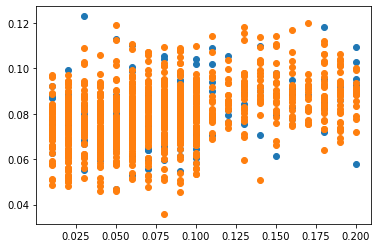

In [372]:
plt.scatter(y_test, gs.best_estimator_.predict(X_test))
plt.scatter(y_train, gs.best_estimator_.predict(X_train))

In [379]:
gs_rf = RandomizedSearchCV(estimator=est_rf, param_distributions={'rf__max_leaf_nodes': [i for i in range(2,20)],
                                                   'rf__n_estimators': [i for i in range(1,25)],
                                                   'rf__max_features': [i for i in range(1,30)],
                                               }, 
                  n_iter = 100,
                  scoring='neg_mean_absolute_error', cv=3, refit=True, verbose=10)

gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] rf__n_estimators=22, rf__max_leaf_nodes=10, rf__max_features=21 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__n_estimators=22, rf__max_leaf_nodes=10, rf__max_features=21, score=-0.036, total=   0.6s
[CV] rf__n_estimators=22, rf__max_leaf_nodes=10, rf__max_features=21 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  rf__n_estimators=22, rf__max_leaf_nodes=10, rf__max_features=21, score=-0.036, total=   0.6s
[CV] rf__n_estimators=22, rf__max_leaf_nodes=10, rf__max_features=21 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  rf__n_estimators=22, rf__max_leaf_nodes=10, rf__max_features=21, score=-0.038, total=   0.6s
[CV] rf__n_estimators=20, rf__max_leaf_nodes=17, rf__max_features=17 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV]  rf__n_estimators=20, rf__max_leaf_nodes=17, rf__max_features=17, score=-0.037, total=   0.5s
[CV] rf__n_estimators=20, rf__max_leaf_nodes=17, rf__max_features=17 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV]  rf__n_estimators=20, rf__max_leaf_nodes=17, rf__max_features=17, score=-0.035, total=   0.6s
[CV] rf__n_estimators=20, rf__max_leaf_nodes=17, rf__max_features=17 .


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


[CV]  rf__n_estimators=20, rf__max_leaf_nodes=17, rf__max_features=17, score=-0.039, total=   0.7s
[CV] rf__n_estimators=5, rf__max_leaf_nodes=18, rf__max_features=24 ..


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s remaining:    0.0s


[CV]  rf__n_estimators=5, rf__max_leaf_nodes=18, rf__max_features=24, score=-0.037, total=   0.3s
[CV] rf__n_estimators=5, rf__max_leaf_nodes=18, rf__max_features=24 ..


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.9s remaining:    0.0s


[CV]  rf__n_estimators=5, rf__max_leaf_nodes=18, rf__max_features=24, score=-0.035, total=   0.3s
[CV] rf__n_estimators=5, rf__max_leaf_nodes=18, rf__max_features=24 ..


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.3s remaining:    0.0s


[CV]  rf__n_estimators=5, rf__max_leaf_nodes=18, rf__max_features=24, score=-0.039, total=   0.3s
[CV] rf__n_estimators=8, rf__max_leaf_nodes=19, rf__max_features=2 ...
[CV]  rf__n_estimators=8, rf__max_leaf_nodes=19, rf__max_features=2, score=-0.039, total=   0.2s
[CV] rf__n_estimators=8, rf__max_leaf_nodes=19, rf__max_features=2 ...


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.6s remaining:    0.0s


[CV]  rf__n_estimators=8, rf__max_leaf_nodes=19, rf__max_features=2, score=-0.039, total=   0.2s
[CV] rf__n_estimators=8, rf__max_leaf_nodes=19, rf__max_features=2 ...
[CV]  rf__n_estimators=8, rf__max_leaf_nodes=19, rf__max_features=2, score=-0.040, total=   0.2s
[CV] rf__n_estimators=23, rf__max_leaf_nodes=10, rf__max_features=3 ..
[CV]  rf__n_estimators=23, rf__max_leaf_nodes=10, rf__max_features=3, score=-0.038, total=   0.3s
[CV] rf__n_estimators=23, rf__max_leaf_nodes=10, rf__max_features=3 ..
[CV]  rf__n_estimators=23, rf__max_leaf_nodes=10, rf__max_features=3, score=-0.037, total=   0.2s
[CV] rf__n_estimators=23, rf__max_leaf_nodes=10, rf__max_features=3 ..
[CV]  rf__n_estimators=23, rf__max_leaf_nodes=10, rf__max_features=3, score=-0.040, total=   0.3s
[CV] rf__n_estimators=15, rf__max_leaf_nodes=8, rf__max_features=21 ..
[CV]  rf__n_estimators=15, rf__max_leaf_nodes=8, rf__max_features=21, score=-0.037, total=   0.4s
[CV] rf__n_estimators=15, rf__max_leaf_nodes=8, rf__max_fea

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-999,
                                                                                                              strategy='constant'))]),
                                                                               ['crime_burglary',
                                                                                'crime_risk',
                                                                                'Norm_fire_risk',
                                                                                'crime_arson',
                                                                         

In [380]:
print("best params: {}".format(gs_rf.best_params_))
print("best score: {}".format(gs_rf.best_score_))
print("model score mae: %.3f" % mean_absolute_error(y_test, gs_rf.best_estimator_.predict(X_test)))
print("model r2 score : %.3f" % r2_score(y_test, gs_rf.best_estimator_.predict(X_test)))

best params: {'rf__n_estimators': 15, 'rf__max_leaf_nodes': 16, 'rf__max_features': 24}
best score: -0.036248601280754966
model score mae: 0.038
model r2 score : 0.170


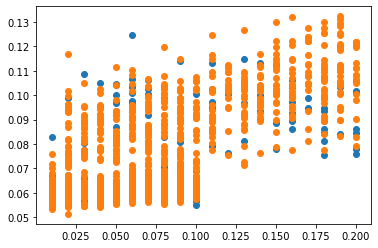

In [381]:
plt.scatter(y_test, gs_rf.best_estimator_.predict(X_test))
plt.scatter(y_train, gs_rf.best_estimator_.predict(X_train))

#### The random forest pipeline has slightly better results by mae, but almost twice better R2.